This notebook was made with reference to this tutorial: https://github.com/bentrevett/pytorch-sentiment-analysis

In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00


In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import tqdm

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [43]:
# load the csv files using load_dataset() function from huggingface
train_data = datasets.load_dataset("csv", data_files="DL_train.csv", split="train") # data/DL/DL_train.csv
test_data = datasets.load_dataset("csv", data_files="DL_test.csv", split="train") # data/DL/DL_test.csv

In [44]:
# initialize a tokenizer
tokenizer = get_tokenizer("basic_english")

In [45]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [46]:
max_length = 100 # from our EDA file, we see that the length of each text does not exceed 100

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [47]:
test_size = 0.1

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [48]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"] # <pad> to pad sequences when they are not long enough

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [49]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [50]:
vocab.set_default_index(unk_index) # so that if some words are not in the vocabulary, we will use <unk> instead of that unknown word

In [51]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [52]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [53]:
train_data = train_data.with_format(type="torch", columns=["ids", "humor", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "humor", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "humor", "length"])

In [15]:
train_data[0]

{'humor': tensor(False),
 'length': tensor(11),
 'ids': tensor([  23, 3392, 4576, 1625, 4314,   69,  780,  637,  737,   20,  504])}

In [54]:
# function to pad indices and do batching

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["humor"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "humor": batch_label}
        return batch

    return collate_fn

In [55]:
# use this custom collate function to format the batch correctly.
# Since there are variable-length sequences that need to be padded to the same length within each batch.

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [56]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

Defining a class for the LSTM

In [19]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [20]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("humor"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [21]:
# number of trainable parameters for the LSTM network
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 8,901,902 trainable parameters


In [22]:
# function to initialize weight of the LSTM network
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [23]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(17637, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:49, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [05:15<00:00, 6956.55it/s]


In [25]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [26]:
model.embedding.weight.data = pretrained_embedding

In [27]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [30]:
model = model.to(device)
criterion = criterion.to(device)

In [31]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [35]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["humor"].type(torch.LongTensor).to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["humor"].type(torch.LongTensor).to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [38]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 32/32 [00:01<00:00, 21.28it/s]


epoch: 0
train_loss: 0.089, train_acc: 0.967
valid_loss: 0.075, valid_acc: 0.972


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 23.88it/s]


epoch: 1
train_loss: 0.074, train_acc: 0.973
valid_loss: 0.085, valid_acc: 0.969


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 27.38it/s]


epoch: 2
train_loss: 0.064, train_acc: 0.976
valid_loss: 0.069, valid_acc: 0.975


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 24.90it/s]


epoch: 3
train_loss: 0.057, train_acc: 0.979
valid_loss: 0.069, valid_acc: 0.976


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 25.30it/s]


epoch: 4
train_loss: 0.049, train_acc: 0.982
valid_loss: 0.068, valid_acc: 0.976


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 19.39it/s]


epoch: 5
train_loss: 0.044, train_acc: 0.984
valid_loss: 0.066, valid_acc: 0.978


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 25.38it/s]


epoch: 6
train_loss: 0.039, train_acc: 0.986
valid_loss: 0.065, valid_acc: 0.977


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 27.60it/s]


epoch: 7
train_loss: 0.035, train_acc: 0.987
valid_loss: 0.067, valid_acc: 0.977


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 23.70it/s]


epoch: 8
train_loss: 0.030, train_acc: 0.989
valid_loss: 0.069, valid_acc: 0.979


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 26.16it/s]

epoch: 9
train_loss: 0.027, train_acc: 0.990
valid_loss: 0.068, valid_acc: 0.978


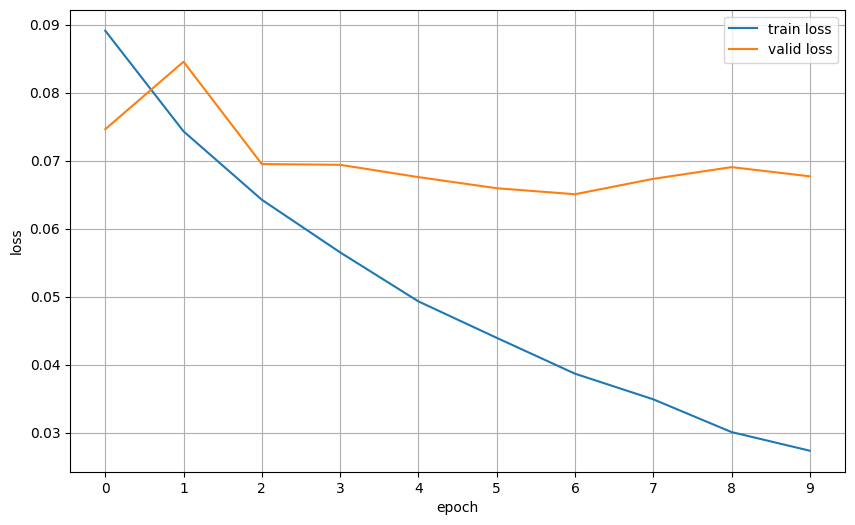

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

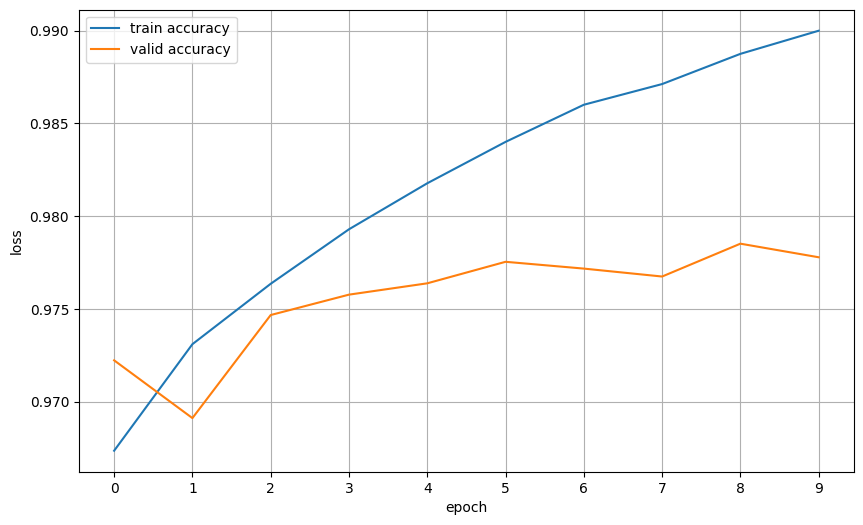

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [57]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 79/79 [00:03<00:00, 22.39it/s]


In [58]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.343, test_acc: 0.891


Function to help predict the sentiment

In [59]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [62]:
text = "how much do pirates pay for corn? a buck an ear!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.999354898929596)

In [64]:
text = "nbc reporter rescues 2 dolphins beached by irma"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999980926513672)